In [1]:
import numpy as np
import matplotlib.pyplot as plt

For Ho-Lee (1986)
$$
\mathbb{V}\text{ar}\left[\ln P(T, T+\delta)\right] = \sigma^2 \delta^2 (T - t)
$$

$$
\sigma_{\text{Black}}^2(T)(T - t)
=
\mathbb{V}\text{ar}\left[\ln P(T, T+\delta)\right]
$$

$$
\sigma_{\text{Black}}(T)
=
\sqrt{\frac{\sigma^2 \delta^2 (T - t)}{T - t}}
=
\sigma\,\delta
$$

and for Hull-White (1990)

$$
\mathbb{V}\text{ar}\left[\ln P(T, T+\delta)\right] \propto \left(1 - e^{-2a(T - t)}\right)
$$

$$
\sigma_{\text{Black}}(T)
=
\sqrt{\frac{1 - e^{-2a(T - t)}}{T - t}}
$$

In [2]:
tenors = np.array([0.5, 1, 2, 3, 5, 7, 10, 15])
y_cc = np.array([0.03, 0.032, 0.035, 0.037, 0.04, 0.042, 0.045, 0.047])
B0 = np.exp(-y_cc * tenors)

In [3]:
def B0_of(T):
    if T <= 0:
        return 1
    return float(np.interp(T, tenors, B0))
def f0_of(t, eps=0.0001):
    t1 = max(t-eps, 0.000001)
    t2 = t+eps
    return - (np.log(B0_of(t2)) - np.log(B0_of(t1))) / (t2 - t1)

In [4]:
sigma_HL = 0.009  # normal vol

def A_HL(t, T):
    # log-form for stability
    logA = np.log(B0_of(T)) - np.log(B0_of(t)) + f0_of(t)*(T-t) - 0.5*sigma_HL**2 * t * (T-t)**2
    return np.exp(logA)

def P_HL(t, T, r_t):
    logP = np.log(A_HL(t,T)) - (T-t) * r_t
    return np.exp(np.clip(logP, -700, 700))

def caplet_black_var_HL(T_fix, delta):
    return (sigma_HL**2) * (delta**2) * T_fix

In [5]:
def simulate_r_HL(T=10, dt=1/12, n_paths=20000, seed=777):
    # Ho Lee simulation
    rng = np.random.default_rng(seed)
    times = np.arange(0, T+dt, dt)
    r = np.zeros((len(times), n_paths))
    for i, t in enumerate(times):
        if i == 0: 
            r[i,:] = f0_of(0.0001)
        else:
            r[i,:] = f0_of(t) + sigma_HL * np.sqrt(t) * rng.standard_normal(n_paths)
    return times, r

In [6]:
a_HW = 0.03
sigma_HW = 0.010

def beta(t, T, a): 
    return (1 - np.exp(-a*(T - t))) / a

def alpha_HW(t, T, a, sigma):
    b = beta(t,T,a)
    term = (sigma**2)/(4*a) * (1 - np.exp(-2*a*t)) * b*b
    log_alpha = np.log(B0_of(T)) - np.log(B0_of(t)) + b * f0_of(t) - term
    return np.exp(log_alpha)

def caplet_black_var_HW(T_fix, delta, a=a_HW, sigma=sigma_HW):
    return (sigma**2 / a**2) * (np.exp(-a*delta) - 1)**2 * (1 - np.exp(-2*a*T_fix)) / (2*a)

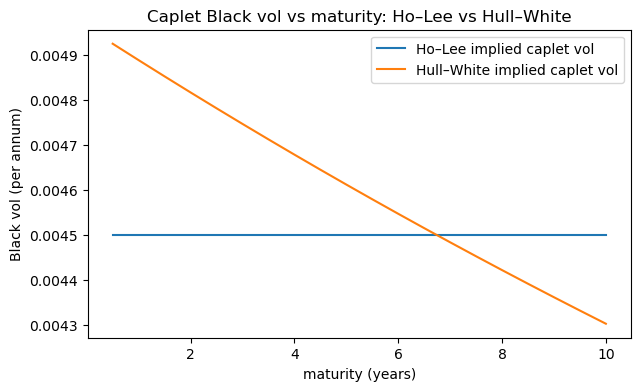

In [11]:
dlt = 0.5
Ts  = np.linspace(0.5, 10, 20)
vol_HL = np.sqrt(np.maximum(1/10**18, [caplet_black_var_HL(T, dlt)/T for T in Ts]))
vol_HW = np.sqrt(np.maximum(1/10**18, [caplet_black_var_HW(T, dlt)/T for T in Ts]))

plt.figure(figsize=(7,4))
plt.plot(Ts, vol_HL, label="Ho–Lee implied caplet vol")
plt.plot(Ts, vol_HW, label="Hull–White implied caplet vol")
plt.xlabel("maturity (years)")
plt.ylabel("Black vol (per annum)")
plt.title("Caplet Black vol vs maturity: Ho–Lee vs Hull–White")
plt.legend()
plt.show()

In [ ]:
# In Ho–Lee the short rate has no mean reversion, so shocks accumulate proportionally over time
# The caplet variance therefore grows linearly in maturity. 
# When converting to Black vol, this variance is divided by maturity, which exactly cancels the growth, resulting in a flat Black implied volatility curve

In [ ]:
# Hull–White introduces mean reversion, so shocks in the distant future are dampened.
# The caplet variance still increases with maturity, but at a decreasing rate (concavity as you see)
# and dividing by maturity produces a downward–sloping Black implied volatility curve

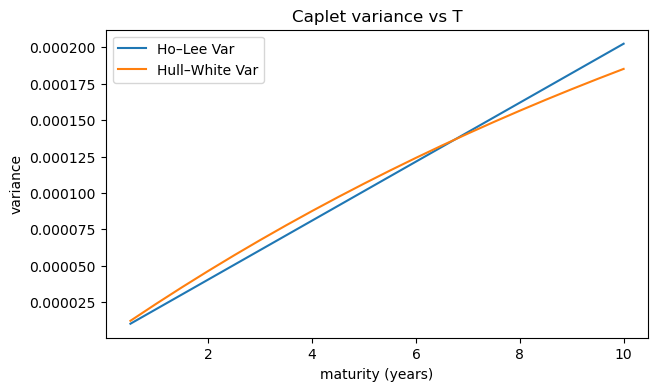

In [10]:
var_HL = np.array([caplet_black_var_HL(T, dlt) for T in Ts])  
var_HW = np.array([caplet_black_var_HW(T, dlt) for T in Ts]) 

plt.figure(figsize=(7,4))
plt.plot(Ts, var_HL, label="Ho–Lee Var")
plt.plot(Ts, var_HW, label="Hull–White Var")
plt.xlabel("maturity (years)")
plt.ylabel("variance")
plt.title("Caplet variance vs T")
plt.legend()
plt.show()

In [ ]:
# The difference becomes especially clear at long maturities
# Ho-Lee continues to accumulate variance linearly, while Hull-White marginally decreses 
# the growth slows and the implied vol falls relative to Ho-Lee
# so that the difference depends on the concavity (ie how negative second order derivative wrt maturity is)

In [8]:
def caplet_price_from_black(t, T, delta, K, var_log, notional=1.0):
    from math import erf
    P_tT   = B0_of(T)
    P_tTd  = B0_of(T+delta)
    X      = (1 + K*delta)
    sigmaP = np.sqrt(var_log)
    d1 = (np.log(P_tT / (X*P_tTd)) + 0.5*sigmaP**2) / sigmaP
    d2 = d1 - sigmaP
    Phi = lambda z: 0.5*(1+erf(z/np.sqrt(2)))
    price = notional*delta*( P_tT*Phi(d1) - X*P_tTd*Phi(d2) )
    return price

K = 0.045
T_fix = 5
price_HL = caplet_price_from_black(0, T_fix, dlt, K, caplet_black_var_HL(T_fix, dlt))
price_HW = caplet_price_from_black(0, T_fix, dlt, K, caplet_black_var_HW(T_fix, dlt))
print(f"Caplet (T={T_fix}, delta={dlt}, K={K:.4f})  Ho–Lee: {price_HL:.6f}   Hull–White: {price_HW:.6f}")

Caplet (T=5, delta=0.5, K=0.0450)  Ho–Lee: 0.001733   Hull–White: 0.001774
